<a href="https://colab.research.google.com/github/isippalpers/Atmospheric_chem/blob/main/EAS4610_Final_HM_ISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video Walkthrough: www.url.com
# Introduction

### Main Theme
The primary focus of this study is to understand the dynamics of the jet stream under zonally asymmetric thermal forcing, specifically solving the second-order partial differential equation presented in PNAS, 2022 (Equation 1). This equation describes the interaction of vertical velocity gradients, thermal forcing, and dissipation effects. The relationship between these parameters is important when modeling the amplitude of jet stream troughs and ridges.

Understanding the amplitude and propagation of troughs and ridges is critical due to their role in midlatitude climate patterns. The strength and amplitude of the jet stream is detirmined by the temperature gradient between the equator and polar regions. Under global warming, a more amplified jet with more high latitude blocking could exacerbate flooding, droughts, and heatwaves. Unlike prior studies using idealized barotropic models or purely observational datasets, this project employs a numerical approach to solve the provided equation, which incorporates surface thermal forcing effects and dissipation terms not previously analyzed in detail.
### Observations, Models, and Methods Used by Others

Several studies in the literature have explored jet stream dynamics and the influence of thermal forcing through various approaches. Here, we highlight how these differ from the methodology and scope of this project:

1. **Observational Studies**  
   Observational analyses, such as those using satellite data and reanalysis datasets (e.g., ERA5, NCEP/NCAR), have been widely used to study jet stream behavior. These studies focus on identifying historical trends in jet stream behavior, such as shifts in position, changes in amplitude, and persistence of troughs and ridges. While observational data provide empirical evidence of jet stream variability, they are limited by their inability to isolate specific physical mechanisms or predict future behavior under different forcing scenarios.

2. **Idealized Barotropic Models**  
   Some researchers have employed idealized models based on barotropic vorticity equations. These models are effective in capturing large-scale features of the jet stream but often neglect vertical structure and thermal forcing explicitly. Thermal wind in particular describes the vertical geostrophc wind sheer in the atmosphere and is one of the primary mechinisms for what drives the jet stream. Therefore, understanding the vertical profile of a jet streak is especially important. An example of this is that many models might use simplified parameterizations for the Coriolis effect and omit the vertical coupling between layers that is critical for understanding wave amplification mechanisms.

3. **Fully Coupled Climate Models**  
   Coupled general circulation models (GCMs), such as those used in CMIP experiments, incorporate a comprehensive set of physical processes, including radiative forcing, land-sea interactions, and ocean-atmosphere coupling. These models are powerful for assessing long-term climate trends but are computationally expensive and less suited for isolating specific processes, such as the effect of zonally asymmetric thermal forcing on jet stream waviness.

4. **Linear Stability Analysis**  
   Linear stability theory has also been applied to examine the conditions under which the jet stream becomes unstable and develops large-amplitude waves. These studies are useful for understanding thresholds of instability but often rely on simplified assumptions about atmospheric stratification and uniformity.

### Differences from the Current Project

This project adopts a **numerical solution approach** to directly solve a second-order partial differential equation governing vertical jet stream dynamics. Key distinctions include:
- **Vertical Structure**: The equation explicitly includes terms representing vertical velocity gradients and dissipation, which are often approximated or excluded in simpler models.
- **Thermal Forcing Representation**: Unlike observational studies or idealized models, this project incorporates a zonally asymmetric thermal forcing term, allowing for a more nuanced understanding of the surface forcing effects.
- **Numerical Methods**: By employing the Gauss-Seidel Method scheme and pre-installed PDE solver on Python, this project balances stability and computational efficiency, which is not always achievable in fully coupled GCMs or linear analyses.

In summary, while other approaches provide valuable insights into jet stream behavior, this project's methodology focuses on a process-level understanding of thermal forcing and dissipation effects using targeted numerical solutions. This distinguishes it from observational and climate modeling studies that prioritize broader atmospheric phenomena.

# Equations

The governing equation (Equation 1) is:

$$
\frac{\partial^2 \phi_L}{\partial z^2} - \frac{1}{H} \frac{\partial \phi_L}{\partial z} + \frac{\beta_L S}{U} \phi_L = -\left(k_s + \frac{1}{H}\right)\frac{Q_0}{U} F(x) e^{-k_s z},
$$

where:
- $\phi_L$: Streamfunction perturbation amplitude.
- $z$: Vertical coordinate.
- $H$: Scale height of the atmosphere.
- $\beta_L$: Meridional gradient of the Coriolis parameter.
- $S$: Stability parameter.
- $U$: Zonal wind velocity.
- $k_s$: Decay rate constant.
- $Q_0$: Surface thermal forcing amplitude.
- $F(x)$: Function representing the horizontal distribution of forcing.

### Assumptions
1. Hydrostatic balance is assumed in the derivation.
2. $F(x)$ varies sinusoidally to represent zonal thermal forcing.
3. The medium is dry and adiabatic, excluding moisture feedback.

### Boundary Conditions and Initial Conditions
- Boundary conditions:
  $$
  \phi_L(0) = 0, \quad \frac{\partial \phi_L}{\partial z} \bigg|_{z \to \infty} = 0
  $$
- Initial condition: Streamfunction perturbations are initially zero at all heights.

---


# Equations

In [ ]:
#defining parameters, boundary conditions, initial conditions
#model code
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import lu

# Parameters
Nz = 100  # Number of z grid points
Nx = 100  # Number of x grid points
z_max = 1.0  # Maximum z (scaled for better matching)
x_max = 2 * np.pi  # Period of cosine forcing
dz = z_max / N_z
dx = x_max / N_x

# Given constants
ks = 2.0       # Damping coefficient
H = 0.5        # Scale height
beta_L = 1.0   # Beta effect coefficient
S = 1.0        # Stratification
U = 1.5        # Background velocity
Q0 = 3
# Define parameters
Lx = 2 * np.pi  # Domain length in x
Lz = 1.0        # Domain height in z
G = lambda x: np.sin(2 * x)/2  # Forcing function G(x)

### Assumptions
~~

# Numerical Methods
~~ (why did we choose these methods)

In [ ]:
# Discretization
dx = Lx / Nx
dz = Lz / Nz
x = np.linspace(0, Lx, Nx)
z = np.linspace(0, Lz, Nz)
X, Z = np.meshgrid(x, z)

D1diags = np.array([1/dz**2, -2/dz**2, 1/dz**2])
D2diags = np.array([-1/dz**2, 1/dz**2])

diags1 = np.array([-1,0,1])
diags2 = np.array([-1,0])

D1 = diags(D1diags, diags1, shape=(Nx, Nx)).toarray()
D2 = diags(D2diags, diags2, shape=(Nx, Nx)).toarray()*-1/H
c = beta_L+S/U
D3 = c*np.eye(Nx)
A = D1 + D2 + D3
P, L, Umat = lu(A)
x0 = np.ones([Nx,1])


In [ ]:
answermatrix = np.ones([Nx,Nz])*np.nan
for j in range(1,Nz):
    b = -1*(ks+1/H)*Q0*G(x)*np.exp(-ks*z[j])
    Linv = -1*np.linalg.inv(L)
    T = Linv@Umat
    c = -1 * Linv@b
    for it_count in range(1, 1000):
        x_new = np.zeros_like(x0, dtype=np.float_)
        for i in range(A.shape[0]):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i + 1 :], x0[i + 1 :])
            x_new[i] = (b[i] - s1 - s2) / A[i, i]
        if np.allclose(x0, x_new, rtol=1e-8):
            break
        x0 = x_new
    answermatrix[:,j] = x_new[:,0]

In [ ]:
np.shape(answermatrix)

(100, 100)

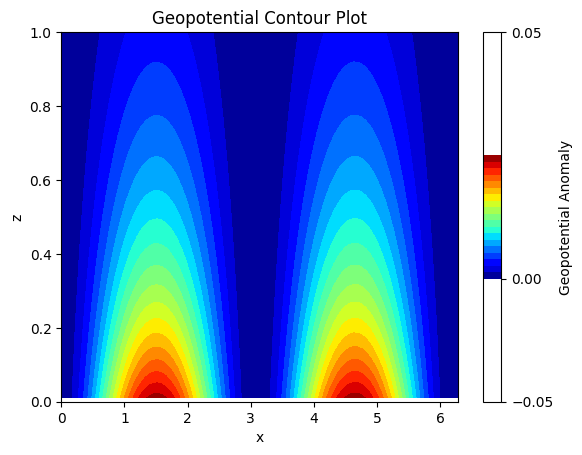

In [ ]:
X, Z = np.meshgrid(x, z)
plt.contourf(X, Z, answermatrix.T, cmap='jet', levels=20)
cbar = plt.colorbar(label='Geopotential Anomaly')
cbar.ax.set_yticks([-0.05,0,0.05])
plt.xlabel('x')
plt.ylabel('z')
plt.title('Geopotential Contour Plot')
plt.show()

# Results

### Simulations we ran (and describe results)
~~
### How do results compare with known solutions
~~
### What did the model tell us about the process
~~
### How could model be improved w.r.t. methods or processes included?
~~

In [ ]:
# ≥4 figures
#labeled axes, variable dimensions are defined

References:
